# 添加一个分类层, 引导生成指定标签的数字

Using device: cuda
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 1, 5, 2, 7, 1, 4, 4])


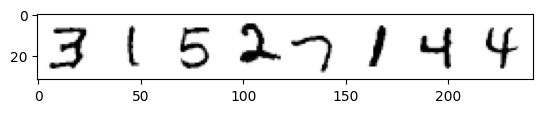

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
# 载入MNIST数据集
dataset = torchvision.datasets.MNIST(root="mnist/", train=True,
   download=True, transform=torchvision.transforms.ToTensor())

# 创建数据加载器
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 查看MNIST数据集中的部分样本，如图5-16所示
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [2]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    # 这个网络层会把数字所属的类别映射到一个长度为class_emb_size的特征向量上
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # self.model是一个不带生成条件的UNet模型，在这里，我们给它添加了额外的
    # 输入通道，用于接收条件信息
    self.model = UNet2DModel(
        sample_size=28,                  # 所生成图片的尺寸
        in_channels=1 + class_emb_size,  # 加入额外的输入通道，
                                         # 用于施加生成条件
        out_channels=1,                  # 输出结果的通道数
        layers_per_block=2,      # 设置一个UNet模块有多少个残差连接层
        block_out_channels=(32, 64, 64),
        down_block_types=(
              "DownBlock2D",      # 常规的ResNet下采样模块
              "AttnDownBlock2D",  # 含有spatial self-attention的
              "AttnDownBlock2D",  # ResNet下采样模块
          ),
          up_block_types=(
              "AttnUpBlock2D",
              "AttnUpBlock2D",    # 含有spatial self-attention
                                  # 的ResNet上采样模块
              "UpBlock2D",        # 常规的ResNet下采样模块
            ),
    )

  # 此时扩散模型的前向计算就会含有额外的类别标签作为输入了
  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape
    # 类别条件将会以额外通道的形式输入
    class_cond = self.class_emb(class_labels) # 将类别映射为向量形式，
                           # 并扩展成类似于(bs, 4, 28, 28)的张量形状
    class_cond = class_cond.view(bs, class_cond.shape[1], 1,
        1).expand(bs, class_cond.shape[1], w, h)

    # 将原始输入和类别条件信息拼接到一起
    net_input = torch.cat((x, class_cond), dim=1) # (bs, 5, 28, 28)

    # 使用模型进行预测
    return self.model(net_input, t).sample    # (bs, 1, 28, 28)

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.051529


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.045101


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.043464


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.042500


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.040899


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.039820


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.039742


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039836


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.039019


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.038893


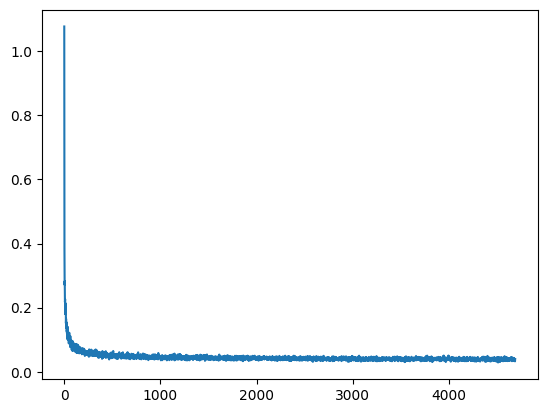

In [4]:
# 创建一个调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,
   beta_schedule='squaredcos_cap_v2')
# 定义数据加载器
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
n_epochs = 10
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []  # 记录损失值

# 训练开始
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # 获取数据并添加噪声
        x = x.to(device) * 2 - 1 # 数据被归一化到区间(-1, 1)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # 预测
        pred = net(noisy_x, timesteps, y) # 注意这里也输入了类别标签y

        # 计算损失值
        loss = loss_fn(pred, noise) # 判断预测结果和实际的噪声有多接近

        # 梯度回传，参数更新
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 保存损失值
        losses.append(loss.item())

    # 输出损失值
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# 可视化训练损失，效果如图5-17所示
plt.plot(losses)

0it [00:00, ?it/s]

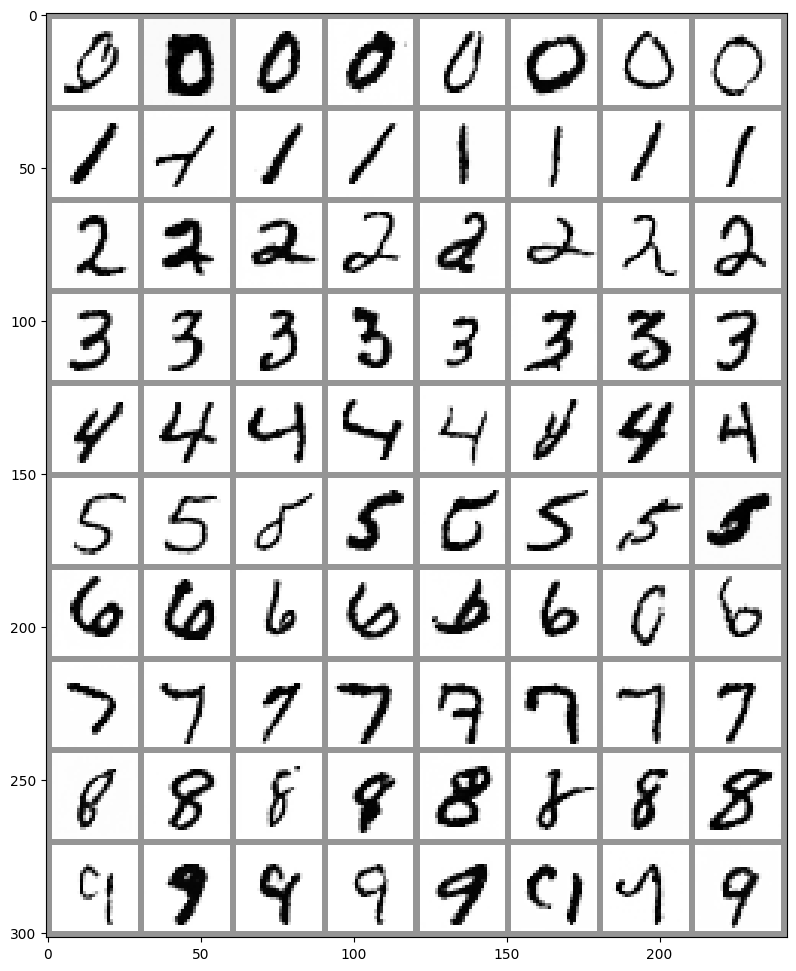

In [5]:
# 准备一个随机噪声作为起点，并准备我们想要的图片的标签
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)  # 指定类别

# 采样循环
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample

# 显示结果，如图5-18所示
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1),
   nrow=8)[0], cmap='Greys')